# PRISMO for MOFA users

## Introduction
This tutorial follows the [MOFA+ vignette on applying MOFA+ to the Chronic Lymphocytic Leukemia cohort](https://raw.githack.com/bioFAM/MOFA2_tutorials/master/R_tutorials/CLL.html) and shows how to achieve equivalent results with PRISMO.
The data consists of four modalities (views): DNA methylation, RNA-seq, somatic mutations, and drug response from a blood for 200 patients with Chronic Lymphocytic Leukemia (CLL).

## Load libraries and data
PRISMO integrates into the [scverse](https://scverse.org) ecosystem, the Python analogon to Bioconductor.
It accepts [AnnData](https://anndata.readthedocs.io) and [MuData](https://mudata.readthedocs.io) containers as input, and many analysis and visualization steps can be achieved with scverse packages such as [scanpy](https://scanpy.readthedocs.io).
For plotting, we use [plotnine](https://plotnine.org), a port of [ggplot2](https://ggplot2.tidyverse.org) to Python.
We additionally import the [rdata](https://rdata.readthedocs.io) package to be able to read the data, which is stored in an R workspace file.

In [1]:
import os.path
from tempfile import TemporaryDirectory
from urllib.request import urlretrieve

import anndata as ad
import mudata as md
import numpy as np
import pandas as pd
import prismo as pr
import rdata
import scanpy as sc
from plotnine import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
theme_set(theme_bw())
md.set_options(display_style="html", display_html_expand=0);

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

We use data from the `MOFAdata` package, which contains the data matrices for the four modalities.
The features are in the rows and samples are in the columns.

In [4]:
with TemporaryDirectory() as tmpdir:
    data_path = os.path.join(tmpdir, "cll.rda")

    urlretrieve(
        "https://github.com/bioFAM/MOFAdata/raw/refs/heads/master/data/CLL_data.RData",
        data_path,
    )
    data = rdata.read_rda(data_path)
metadata = pd.read_table(
    "https://ftp.ebi.ac.uk/pub/databases/mofa/cll_vignette/sample_metadata.txt"
)

[AnnData](https://anndata.readthedocs.io/) is the scverse equivalent to Bioconductor's [SingleCellExperiment](https://bioconductor.org/packages/SingleCellExperiment/).
It can store one or multiple data matrices together with metadata for samples (called observations, `.obs`) and features (called variables, `.var`).
Contrary to the Bioconductor convention, samples are stored in rows and features in columns.
We create one [AnnData](#anndata.AnnData) object for each modality.

The individual modalities are then stored in a [MuData](#mudata.MuData) object, which is the scverse equivalent to Bioconductor's [MultiAssayExperiment](https://www.bioconductor.org/packages/MultiAssayExperiment/).
Because [MuData](#mudata.MuData) takes care of aligning the different modalities with respect to missing samples and PRISMO is written with that in mind, we first remove samples where all features are missing.
We pass the metadata as an `obs` argument to the [MuData](#mudata.MuData) constructor.

In [5]:
mdata = {}
for view_name, view_data in data["CLL_data"].items():
    view_data = view_data[:, np.isnan(view_data).sum(axis=0) < view_data.shape[0]].T
    mdata[view_name] = ad.AnnData(
        X=view_data.values,
        obs=pd.DataFrame(index=view_data.coords["dim_1"].to_index()),
        var=pd.DataFrame(index=view_data.coords["dim_0"].to_index()),
    )
mdata = md.MuData(mdata, obs=metadata.set_index("sample"))

In [6]:
mdata

MuData object with n_obs × n_vars = 200 × 9627
  obs:	'Gender', 'age', 'TTT', 'TTD', 'treatedAfter', 'died', 'IGHV', 'trisomy12'
  4 modalities
    Drugs:	184 x 310
    Methylation:	196 x 4248
    mRNA:	136 x 5000
    Mutations:	200 x 69

## Train the model
The model is automatically trained when a [PRISMO](#prismo.PRISMO) object is created.
The [PRISMO](#prismo.PRISMO) constructor takes the data as its first argument and several objects containing the different settings as its following arguments in arbitrary order.
For this tutorial, we will use 15 factors with a spike-and-slab prior and Gaussian likelihoods for all views.
The spike-and-slab prior typically requires larger learning rates and longer training times than other priors, so we increase the learning rate to 0.01 and the early stopper patience to 500 epochs.

One major difference to the [MOFA+ vignette](https://raw.githack.com/bioFAM/MOFA2_tutorials/master/R_tutorials/CLL.html) is that it uses a Bernoulli likelhood for the `Mutations` modality, which is more appropriate for binary data.
However, PRISMO yields different results compared to MOFA+ when using a Bernoulli likelihood.
This is probably due to the fact that MOFA+ uses a pseudo-Gaussian approximation for non-Gaussian likelihoods for reasons of computational tractability, while PRISMO uses a more exact approach.
The pseudo-Gaussian approximation is likely also the reason that MOFA+ yields very similar results for Bernoulli and Gaussian likelihoods (try running the [MOFA+ vignette](https://raw.githack.com/bioFAM/MOFA2_tutorials/master/R_tutorials/CLL.html) with all Gaussian likelihoods).

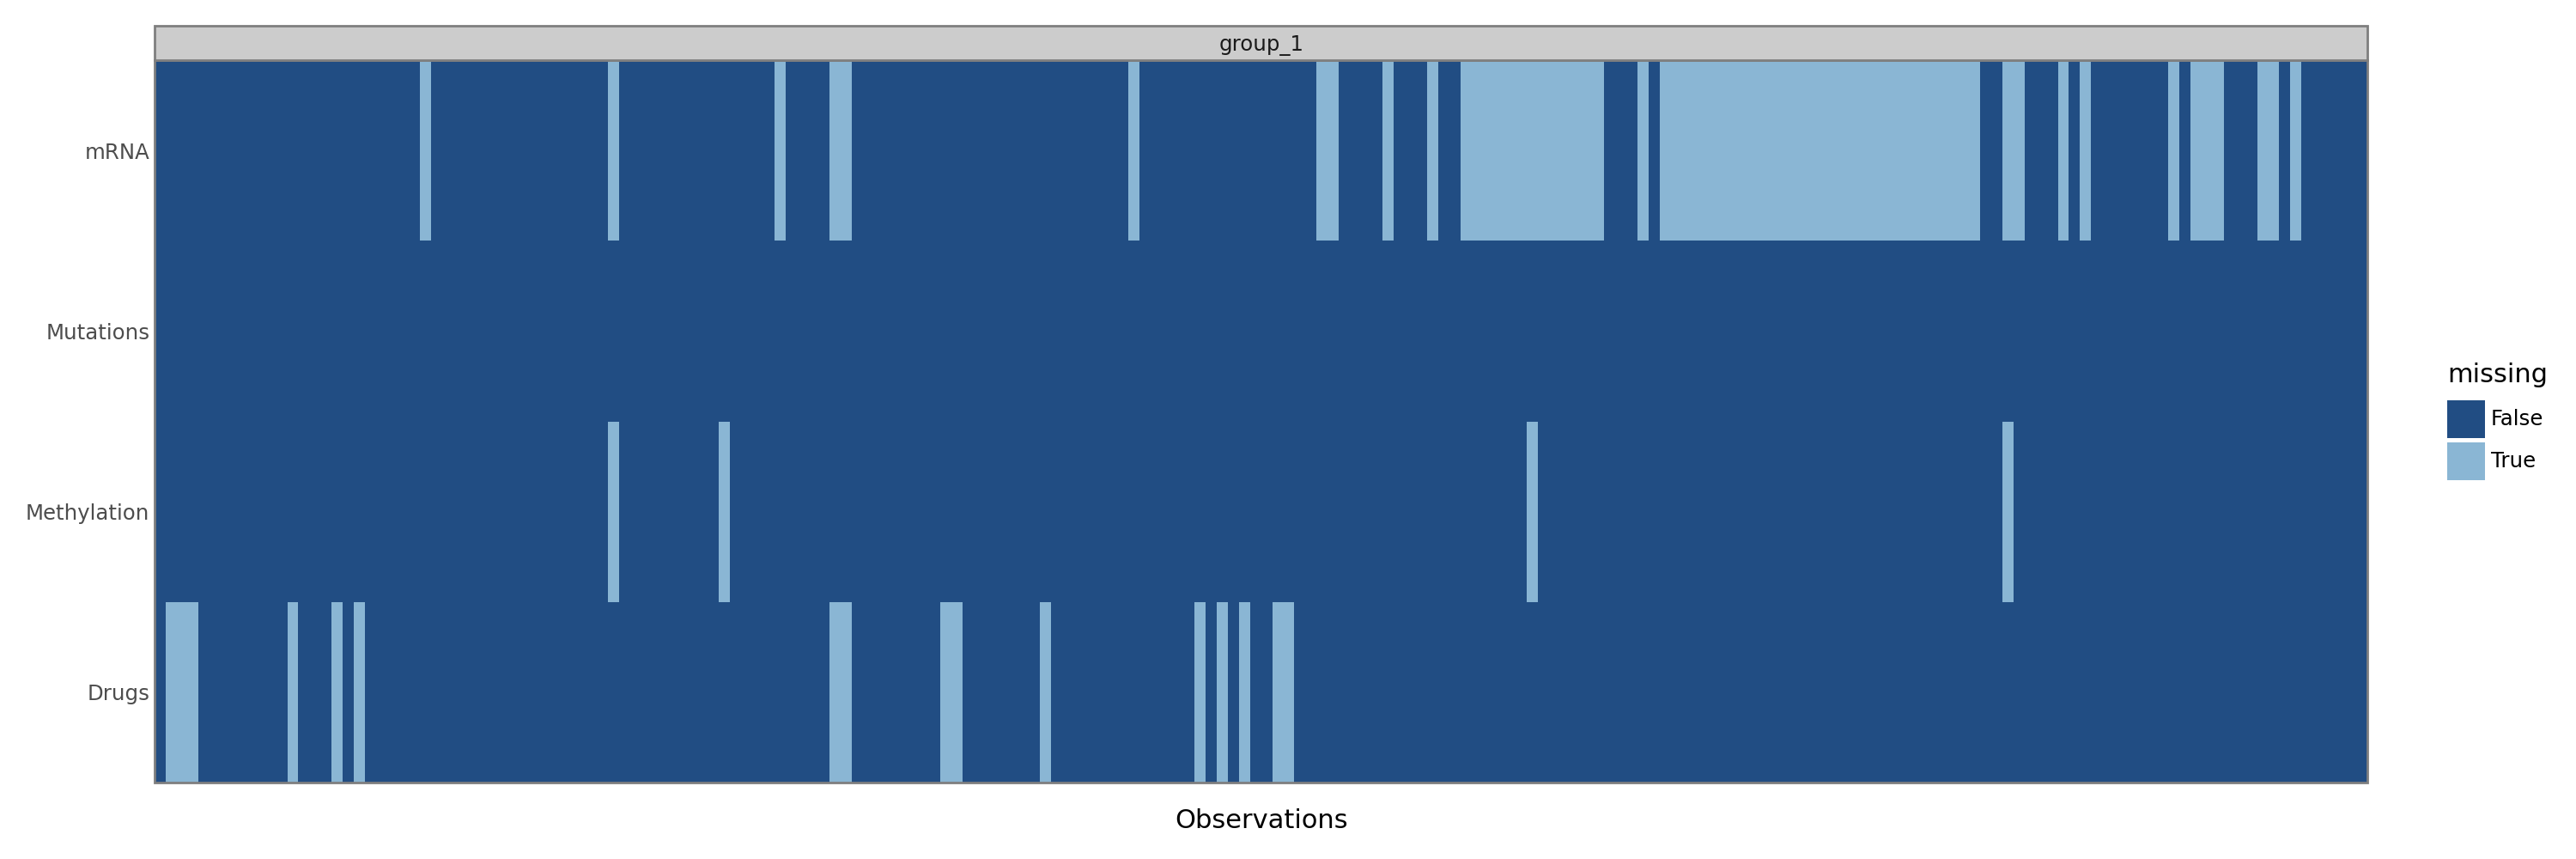

INFO	Initializing factors using `random` method...


  0%|                                                                                                         …

INFO 	 Guessed max_plate_nesting = 3
INFO	Training converged after 3033 epochs.


In [7]:
model = pr.PRISMO(
    mdata,
    pr.ModelOptions(n_factors=15, weight_prior="SnS", likelihoods="Normal"),
    pr.TrainingOptions(seed=42, save_path=False, lr=0.01, early_stopper_patience=500),
)

## Basic quality control and overview of the trained model

### Posterior non-zero probabilities of the spike-and-slab prior
An important quality control plot when using the spike-and-slab prior is the sparsity histogram, which visualizes the posterior probabilities that entries of the weight matrix are non-zero.
Ideally, it has two peaks at 0 and 1, with very few counts at intermediate values.
Should that not be the case, you probably need to increase the learning rate and/or the early stopper patience.

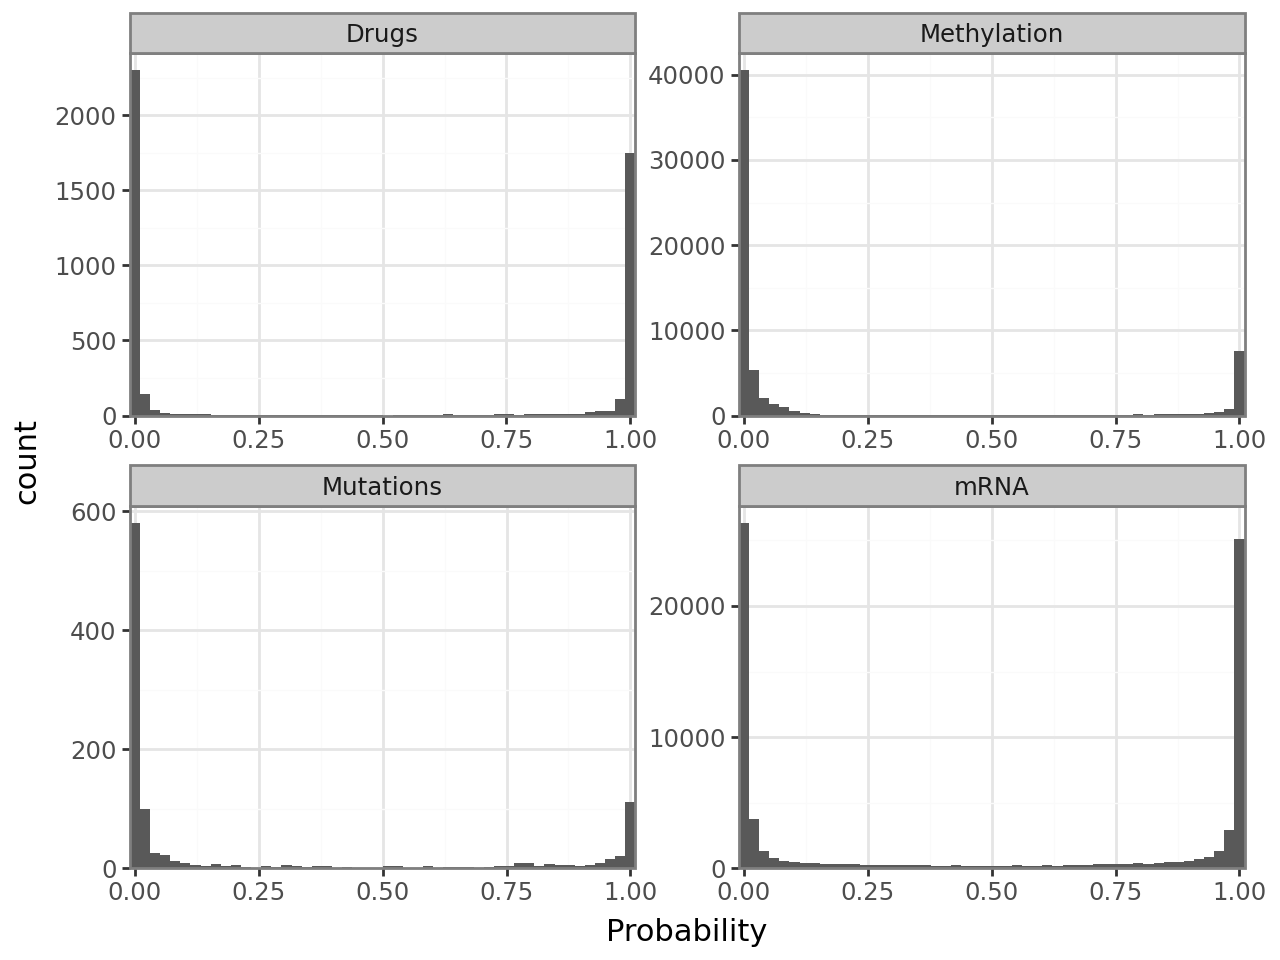

In [8]:
pr.pl.weight_sparsity_histogram(model)

### Correlation between factors
In a well-specified model that is well-supported by the data, the factors should be mostly uncorrelated.
PRISMO, like MOFA, does not impose any orthogonality constraints, but high correlations between many factors suggest a poorly specified model or a mismatch between the model and the data.

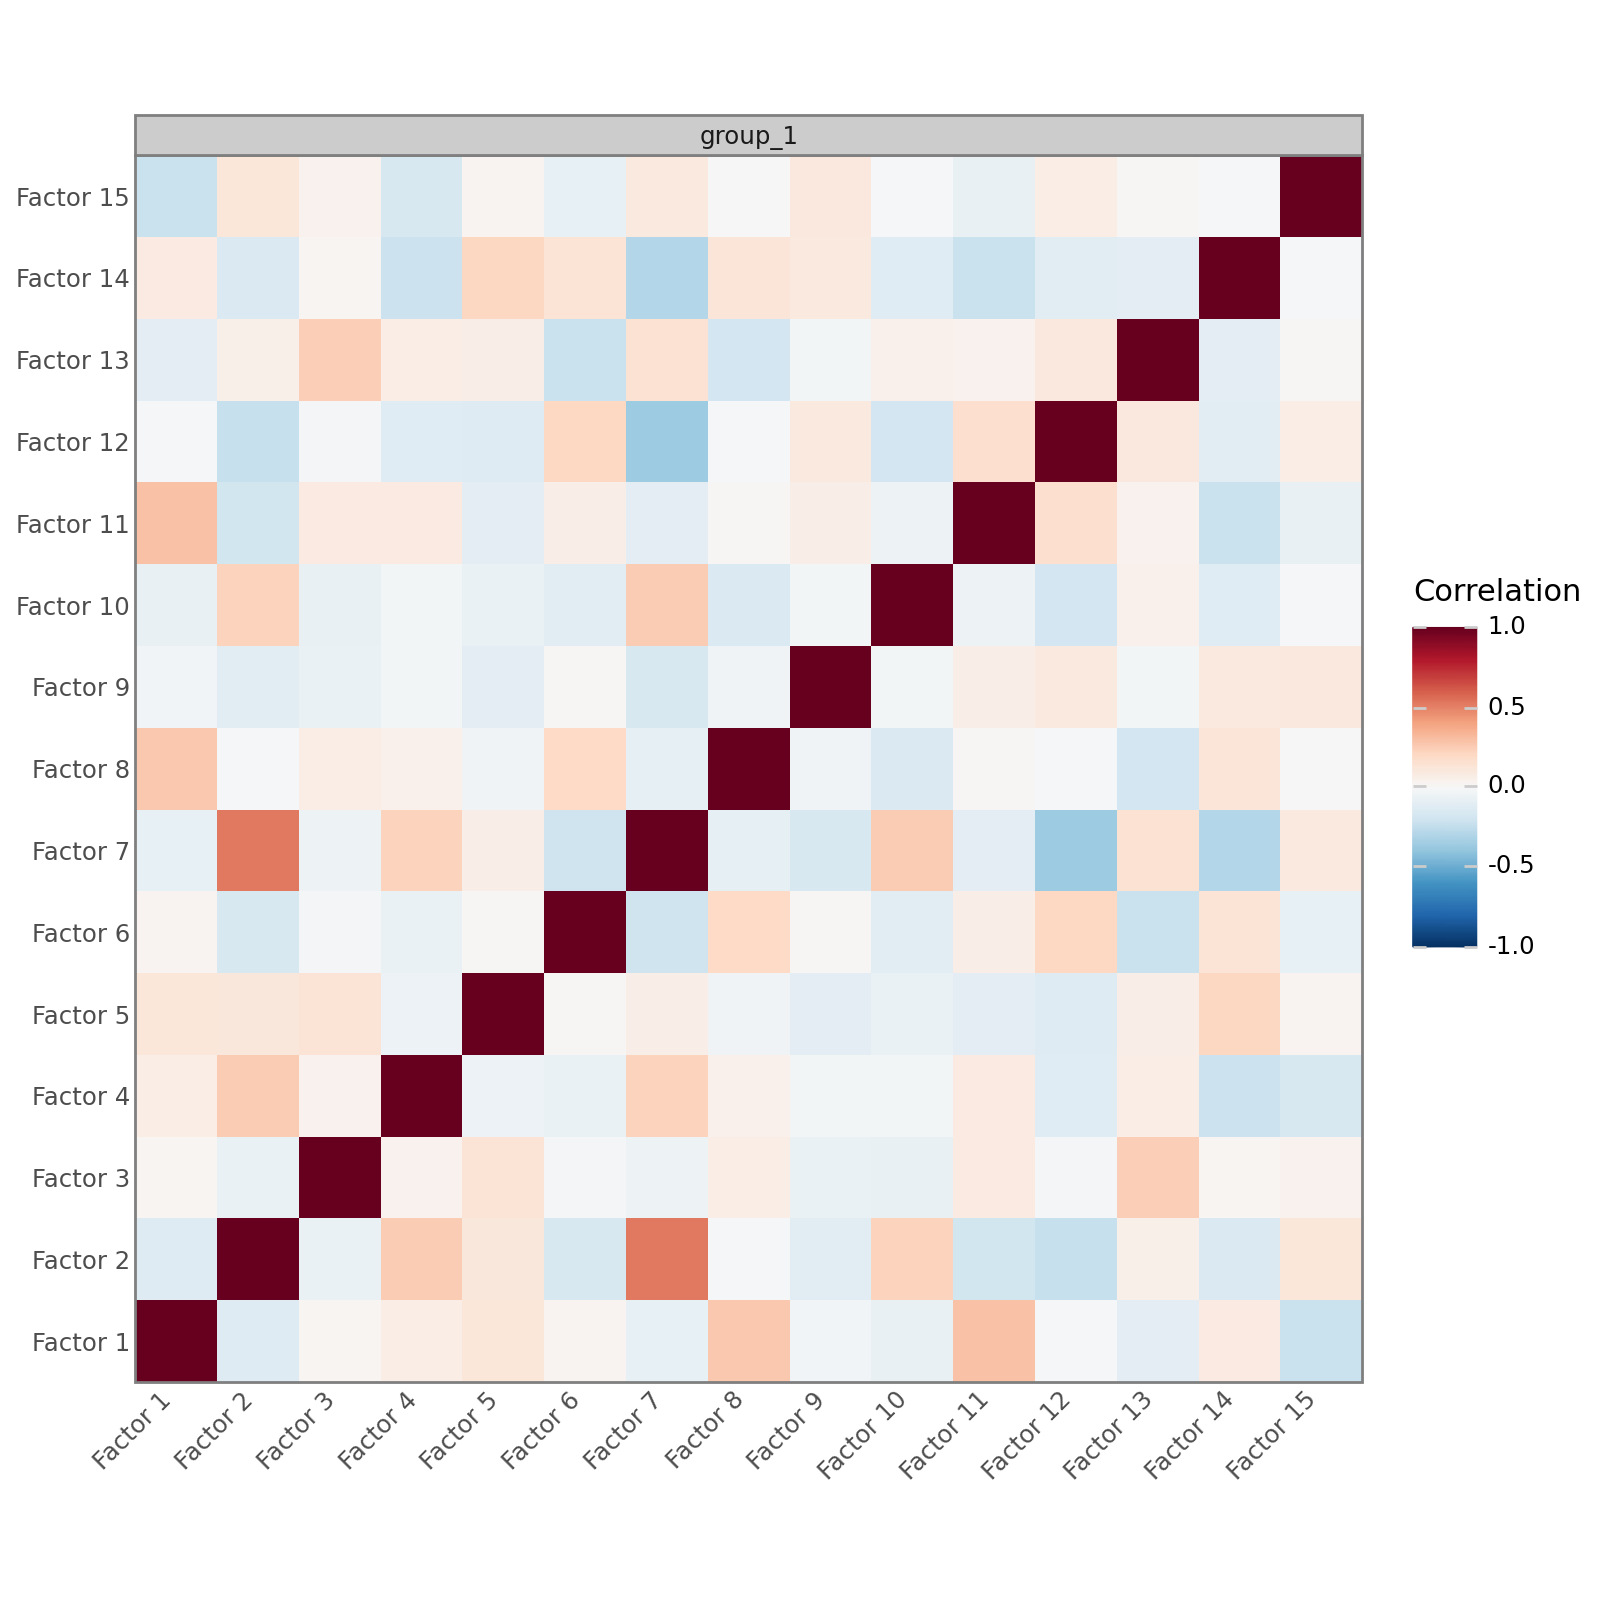

In [9]:
pr.pl.factor_correlation(model)

### Variance decomposition
As in MOFA, the most important plot that PRISMO provides is the variance decomposition analysis, which shows the fraction of variance explained by each factor for all modalities.
Note that this is most reliable for modalities with Gaussian likelihoods.
Non-Gaussian likelihoods, especially the Bernoulli likelihood, may fail to to calculate the fraction of explained variance.
For Bernoulli likelihoods, this is often the case if the data is heavily biased towards 0 or 1 and due to the fact that the predictions are not sufficiently close to 0 or 1, such that simply calculating the mean of the data yields a better prediction that the PRISMO model.
If the fraction of explained variance cannot be calculated for a view, a warning will be printed immediately after training.

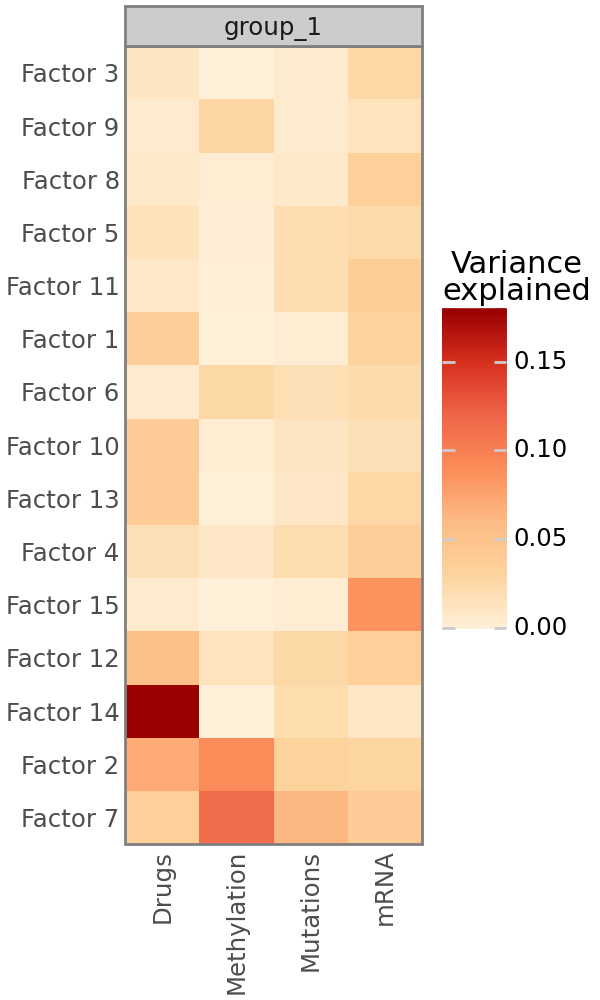

In [10]:
pr.pl.variance_explained(model)

## Characterization of Factor 7

### Plot factor values
Similar to MOFA, PRISMO can plot factor values for each sample.
Analogous to PCA, PRISMO factors can be viewed as a new coordinate system for the data.
Since the data is centered prior to running PRISMO (for modalities with Gaussian likelihoods), each factor is also centered at zero.
Samples with different signs manifest opposite phenotypes along the inferred axis of variation, with higher absolute value indicating a stronger effect.

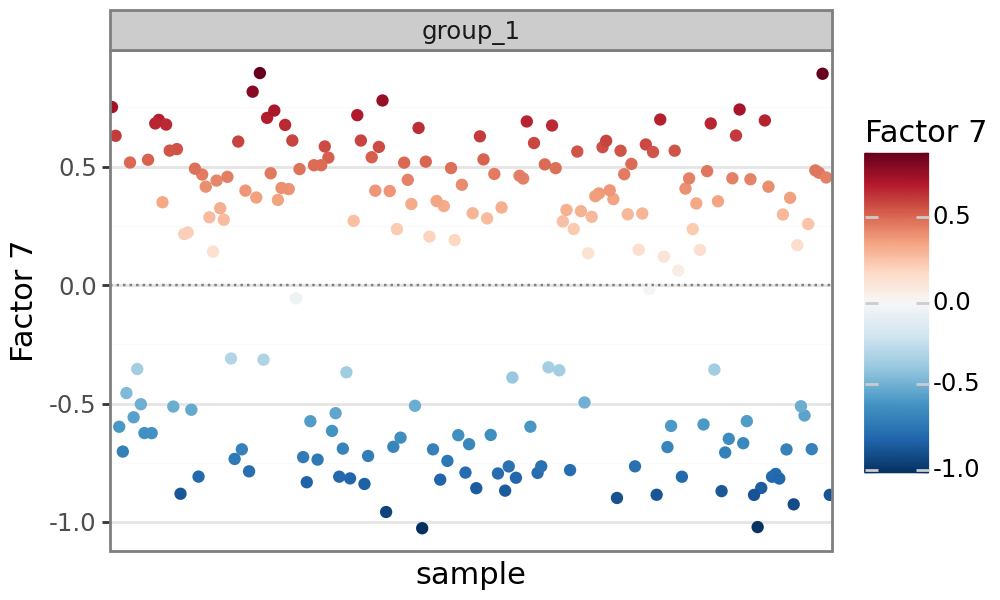

In [11]:
pr.pl.factor(model, factor=7)

### Plot feature weights
The weights provide a score for each feature on each factor.
Features with no association with the corresponding factor should have weights very close to zero, while features strongly associated with a factor should have large absolute weights.
The sign of the weights indicates the direction of the effect: A positive weight indicates that the feature is positively correlated with the factor values, a negative weight indicates that the feature is negatively correlated with the factor.

#### Plot feature weights for somatic mutations
By looking at the variance explained plot, we determined that factor 7 captures variation in all data modalities.
Somatic mutations are very sparse, easy to interpret, and are likely to have downstream effects on other modalities.
We therefore start with the Mutations modality.

We can plot the weights:

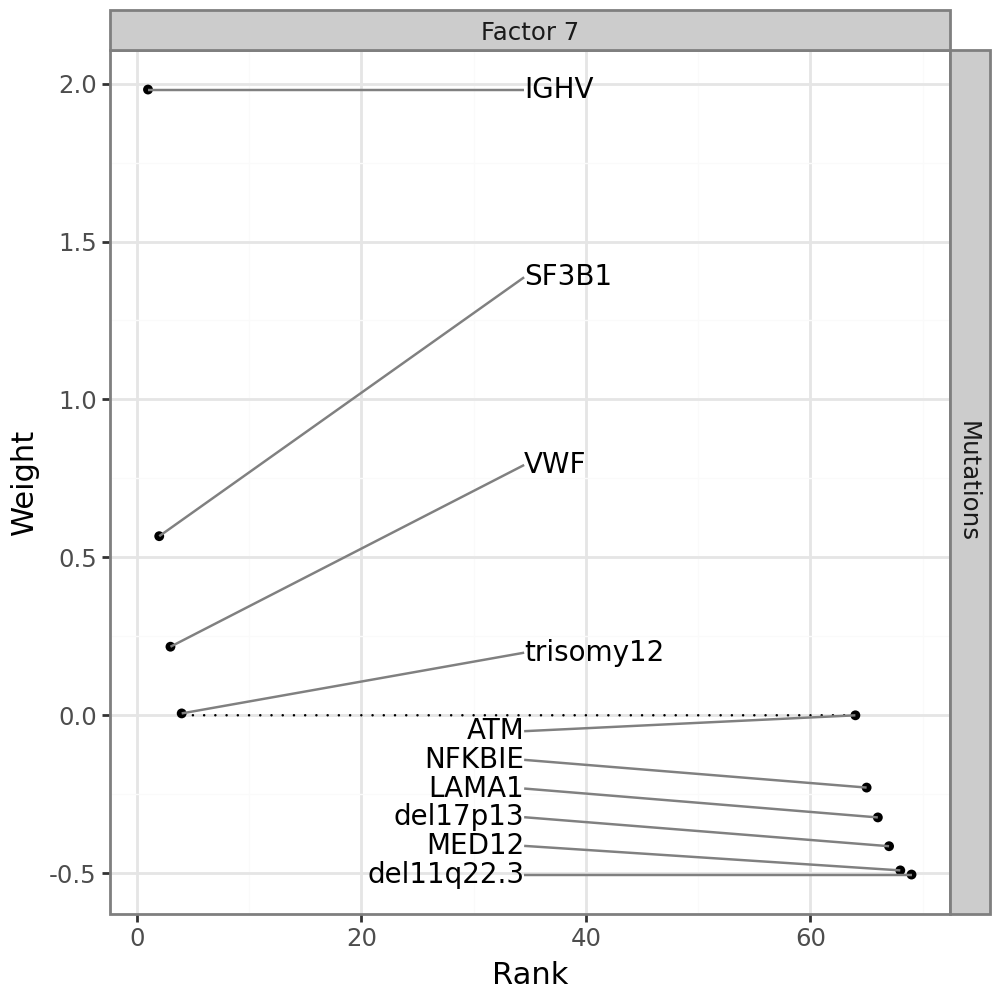

In [12]:
pr.pl.weights(model, n_features=10, views="Mutations", factors=7, figsize=(5, 5))

Most features are zero, indicating that they have no association with factor 7.
One gene stands out: IGHV, the main clinical marker for CLL.

An alternative visualzation to the full weight distribution is a line plot displaying only the top features, annotated with the sign of the corresponding weight;

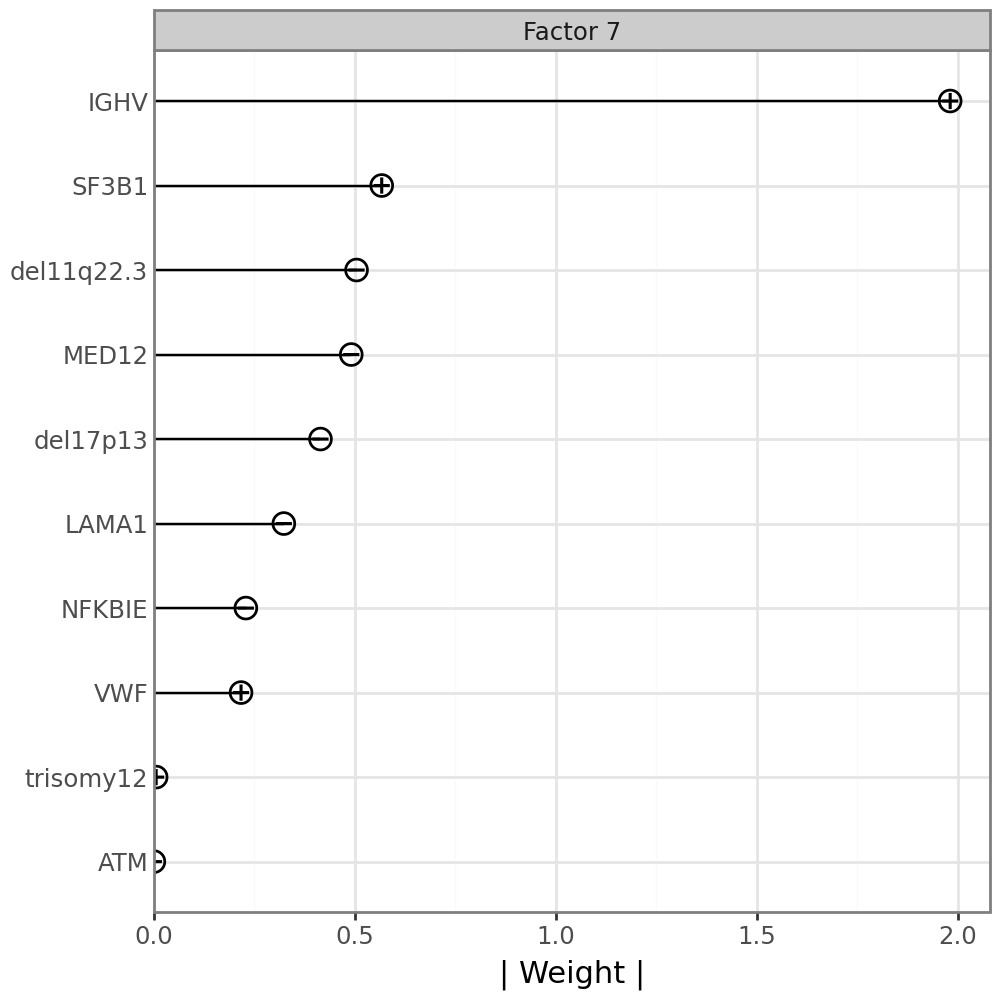

In [13]:
pr.pl.top_weights(model, n_features=10, views="Mutations", factors=7)

IGHV has a positive weight, indicating that samples with positive factor 7 values have an IGHV mutation, while samples with negative factor 7 values do not have an IGHV mutatoin.
To confirm this, we can plot the factor values colored by the IGHV mutation status.

We use [scanpy functionality](#scanpy.get.obs_df) to get a [data frame](#pandas.DataFrame) with the IGHV mutation status in a column and the sample names as the index from the [AnnData](#anndata.AnnData) object we created earlier.
We then add a new column containing values of factor 7 and plot.

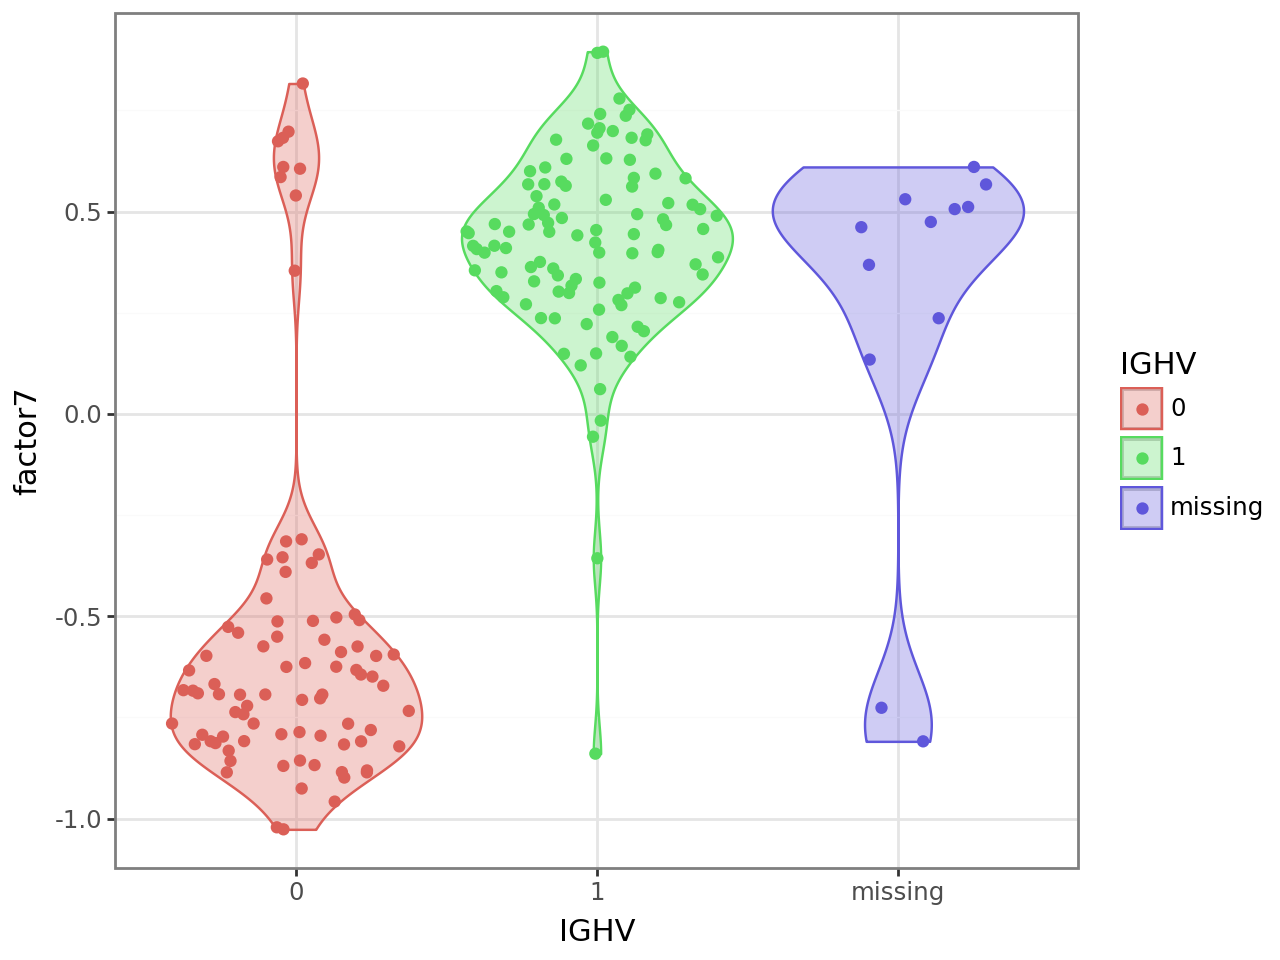

In [14]:
(
    ggplot(
        sc.get.obs_df(mdata["Mutations"], keys="IGHV").assign(
            factor7=model.get_factors()["group_1"]["Factor 7"],
            IGHV=lambda x: x.IGHV.replace({1.0: "1", 0.0: "0", np.nan: "missing"}),
        ),
        aes("IGHV", "factor7", color="IGHV", fill="IGHV", group="IGHV"),
    )
    + geom_violin(alpha=0.3)
    + geom_sina()
)

Similarly, we can use other covariates, which we can get directly from the `.obs` annotation of the [MuData](#mudata.MuData) or [AnnData](#anndata.AnnData) objects.

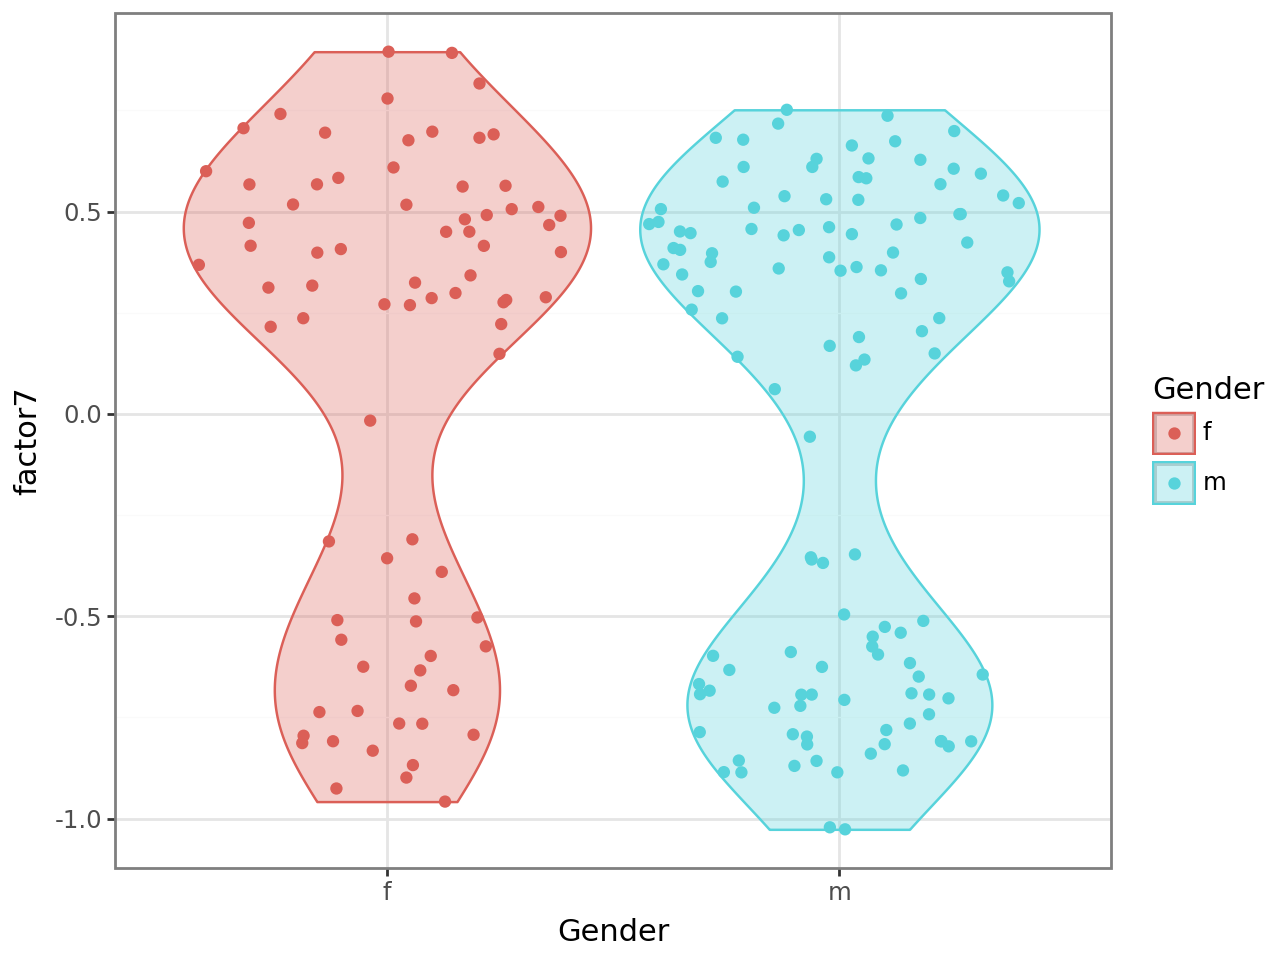

In [15]:
(
    ggplot(
        mdata.obs[["Gender"]].assign(
            factor7=model.get_factors()["group_1"]["Factor 7"]
        ),
        aes("Gender", "factor7", color="Gender", fill="Gender"),
    )
    + geom_violin(alpha=0.3)
    + geom_sina()
)

#### Plot gene weights for mRNA expression
Since factor 7 drives variation across all data modalites, it makes sense to also visualize the mRNA expression changes that are associated with Factor 7:

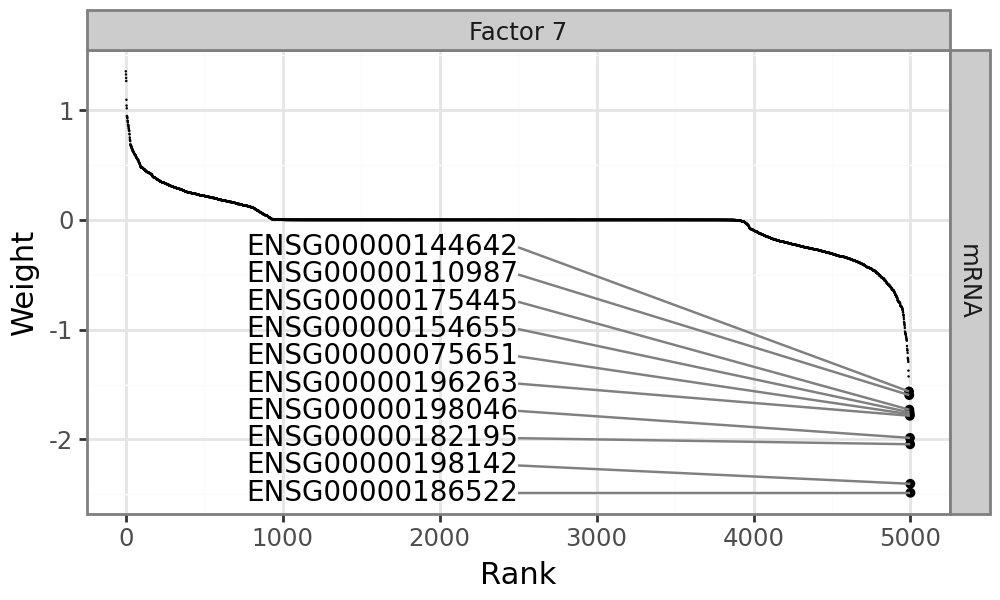

In [16]:
pr.pl.weights(model, n_features=10, views="mRNA", factors=7, figsize=(5, 3))

#### Plot molecular signatures in the input data
In this case, there are many genes with large positive and negative weights.
Genes with large positive weights should be more highly expressed in samples with an IGHV mutation, while genes with large negative values should be more highly expressed in samples without an IGHV mutation.
We can verify this.
Again, we use [scanpy functionality](#scanpy.get.obs_df) to get a [data frame](#pandas.DataFrame) with the expression values of the four genes with the highest (positive) weight and add a new column with factor 7 values.
We then transform the data frame to a format suitable for ggplot and plot, coloring by IGHV mutation status.

In [17]:
f7_weights = model.get_weights()["mRNA"].loc["Factor 7"]

def plot_f7_expression(genes):
    return (
        ggplot(
            sc.get.obs_df(mdata["mRNA"], keys=genes)
            .assign(
                factor7=model.get_factors()["group_1"]["Factor 7"],
                IGHV=sc.get.obs_df(mdata["Mutations"], keys="IGHV").IGHV.replace(
                    {1.0: "1", 0.0: "0", np.nan: "missing"}
                ),
            )
            .melt(
                id_vars=["IGHV", "factor7"], var_name="gene", value_name="expression"
            ),
            aes("factor7", "expression"),
        )
        + geom_point(aes(color="IGHV"))
        + geom_smooth(method="lm")
        + facet_wrap("gene")
    )

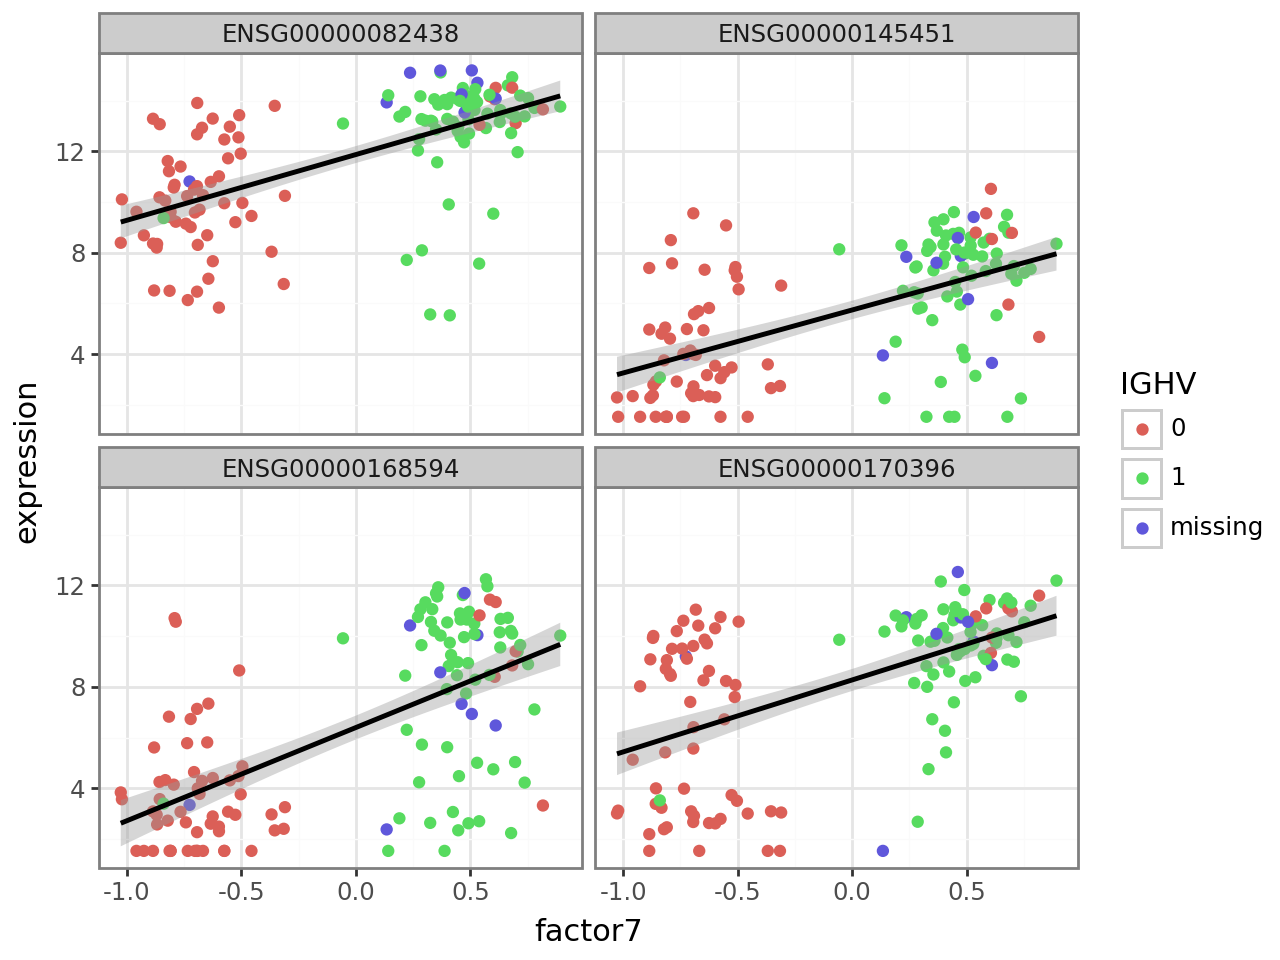

In [18]:
plot_f7_expression(f7_weights.nlargest(4).index.to_list())

Similarly, we plot the four genes with smallest (negative) weight.

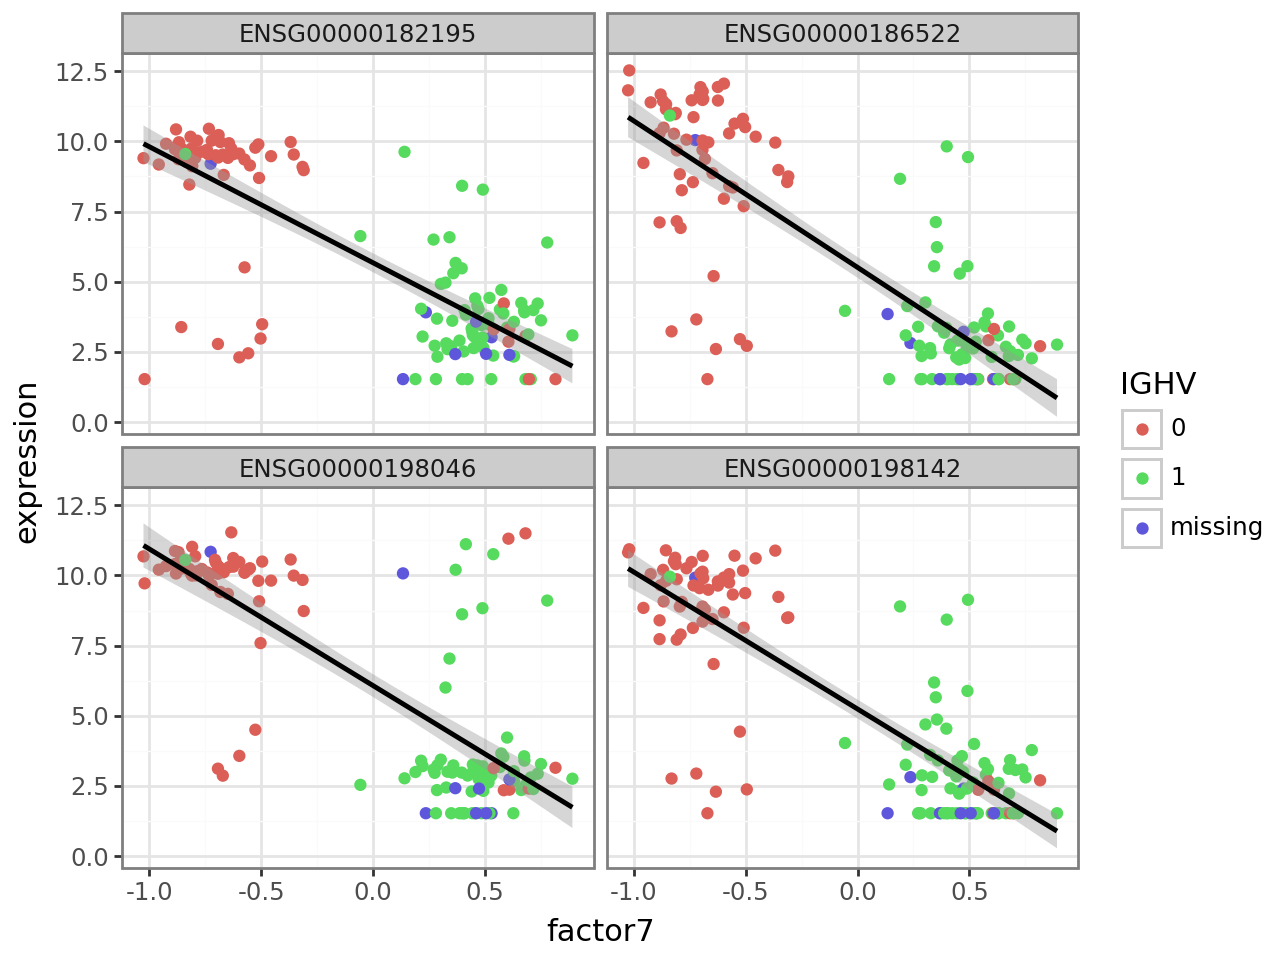

In [19]:
plot_f7_expression(f7_weights.nsmallest(4).index.to_list())

Alternatively, we can use a heatmap to plot gene expression for selected genes across all cells.
[Scanpy provides this functionality](#scanpy.pl.heatmap).
The function takes an [AnnData](#anndata.AnnData) object and a list of genes to plot.
We plot the 25 genes with highest absolute weight and order the samples by factor 7 value to be able to visually discern some patterns.

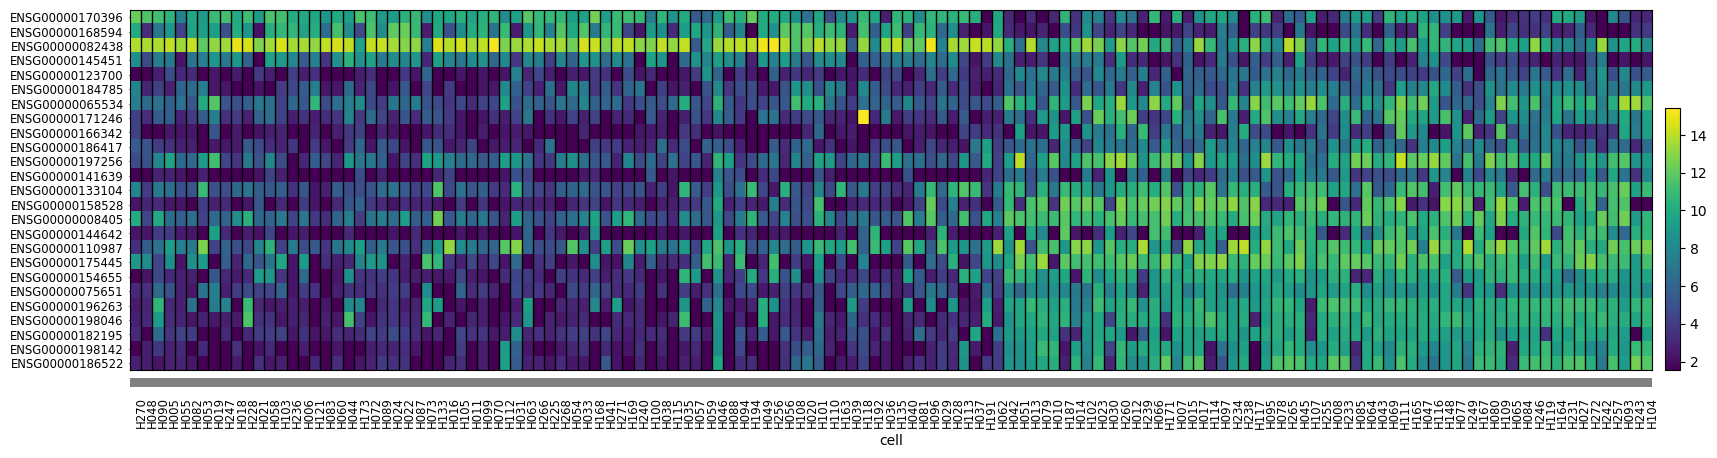

In [20]:
mdata["mRNA"].obs["cell"] = pd.Categorical(
    mdata["mRNA"].obs.index,
    categories=model.get_factors()["group_1"]["Factor 7"]
    .sort_values(ascending=False)
    .index.intersection(mdata["mRNA"].obs.index),
)
sc.pl.heatmap(
    mdata["mRNA"],
    f7_weights.to_frame()
    .assign(absval=lambda x: x["Factor 7"].abs())
    .nlargest(25, "absval")
    .sort_values("Factor 7", ascending=False)
    .index.to_list(),
    "cell",
    swap_axes=True,
    dendrogram=False,
    figsize=(20, 5),
)